In [1]:
#| hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [2]:
#| default_exp inspect.tree

# Decision Tree

> Inspector functionality for tree models

In [3]:
#| export
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from model_inspector.delegate import delegates
from model_inspector.inspect.any_model import _Inspector
from model_inspector.inspect.classifier import _BinInspector, _MultiInspector
from model_inspector.inspect.regressor import _RegInspector
from sklearn.tree import plot_tree

In [4]:
#| export
class _TreeMixin(_Inspector):
    """Mixin for decision tree model inspectors"""

    @delegates(plot_tree)
    def plot_tree(self, ax: Optional[Axes] = None, **kwargs):
        """Show decision tree"""
        if ax is None:
            # these dimensions seem to work well empirically
            max_size = 50
            depth = (
                kwargs["max_depth"] + 1
                if "max_depth" in kwargs
                else self.model.get_depth()
            )
            fig_height = min(depth * 2.2, max_size)
            width = (
                2 * kwargs["max_depth"]
                if "max_depth" in kwargs
                else self.model.get_n_leaves()
            )
            fig_width = min(width * 3.5, max_size)
            _, ax = plt.subplots(figsize=(fig_width, fig_height))
        kwargs = {"filled": True, "fontsize": 12, **kwargs}
        return plot_tree(
            self.model,
            feature_names=self.X.columns,
            class_names=np.unique(self.y).astype(str),
            ax=ax,
            **kwargs,
        )[0].axes

## Decision Tree Regression

In [5]:
#| export
class _TreeRegInspector(_RegInspector, _TreeMixin):
    """Inspector for decision tree regressors models"""

    pass

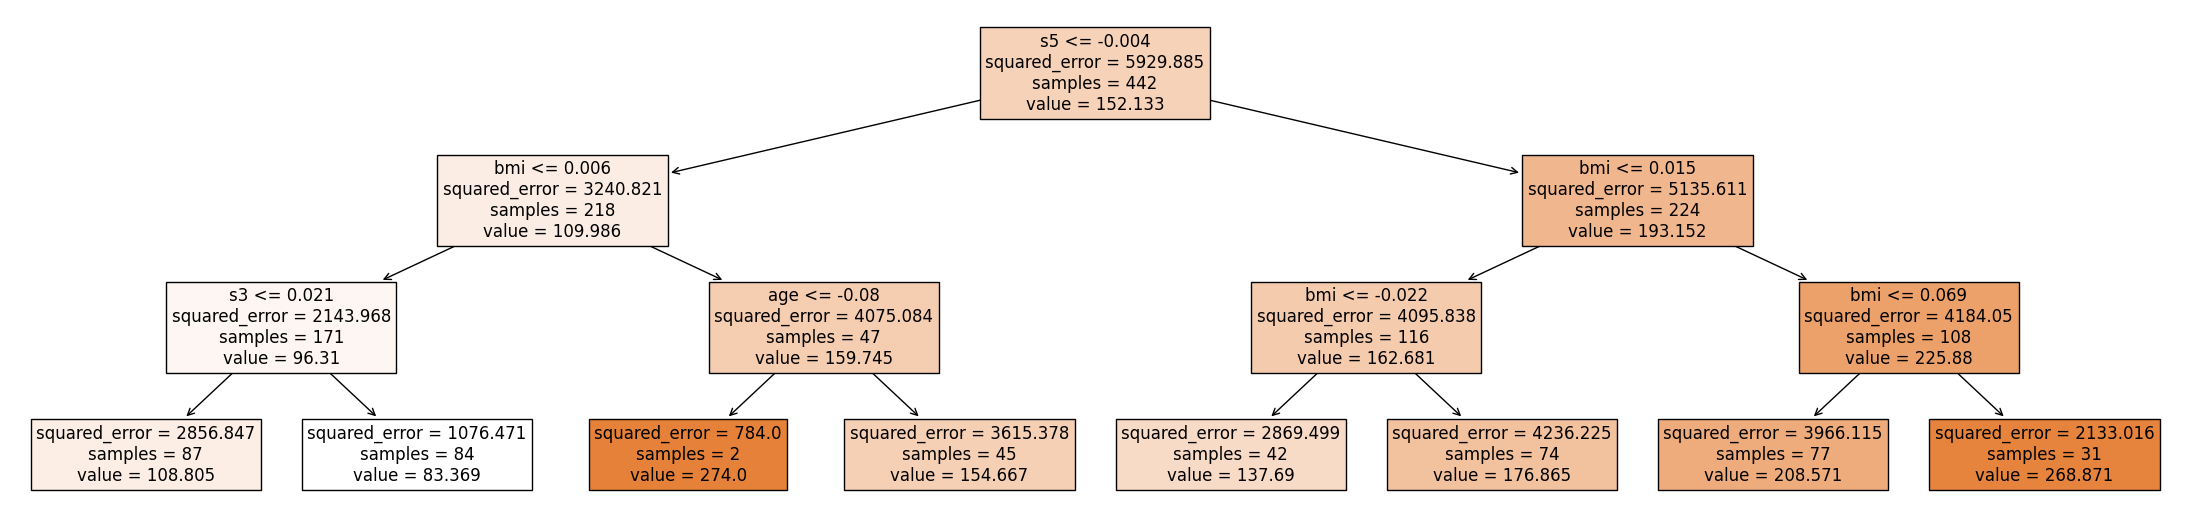

In [6]:
import sklearn.datasets
from model_inspector import get_inspector
from sklearn.tree import DecisionTreeRegressor

X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(DecisionTreeRegressor(max_depth=3).fit(X, y), X, y)

ax = inspector.plot_tree()

## Binary Decision Tree

In [7]:
#| export
class _TreeBinInspector(_BinInspector, _TreeMixin):
    """Inspector for binary decision tree models"""

    pass

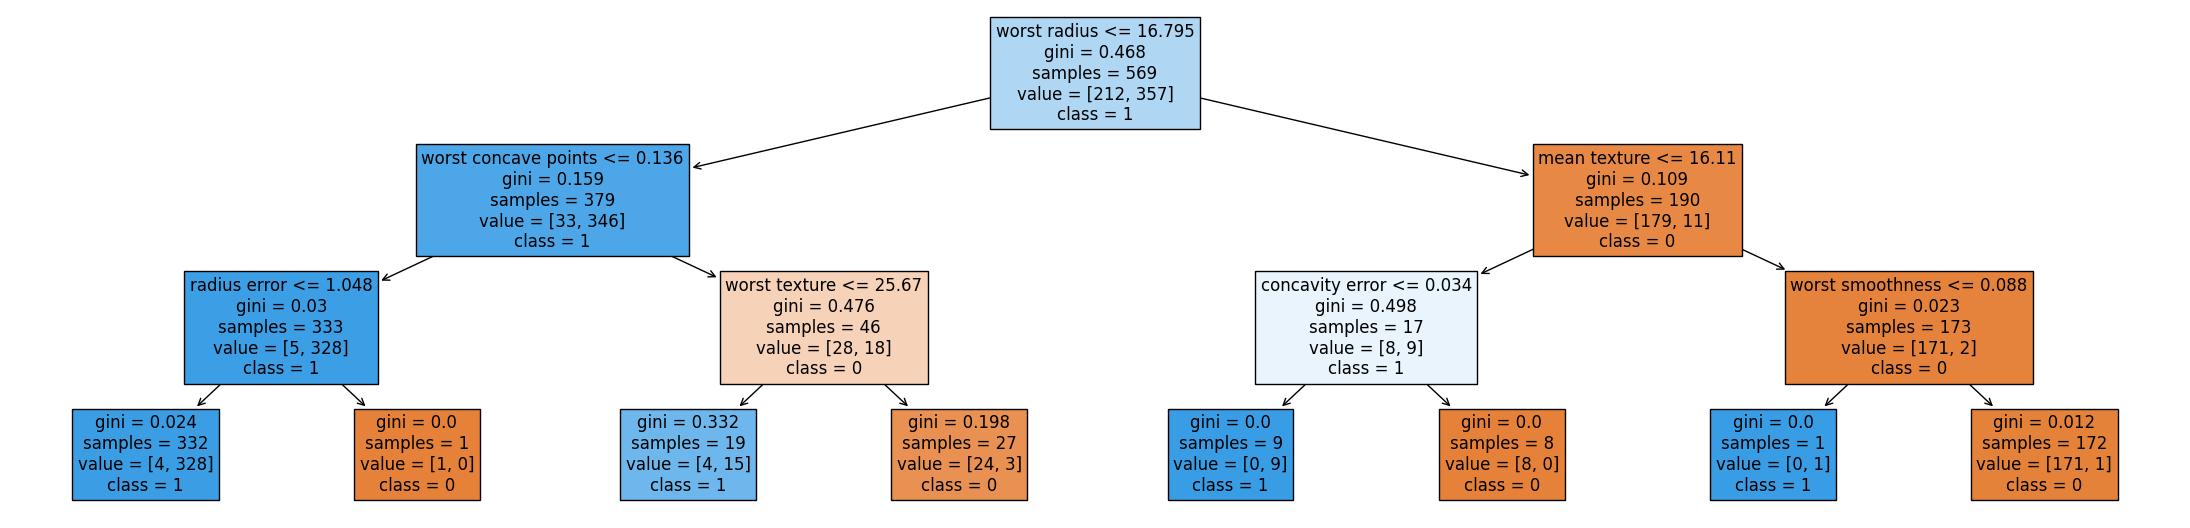

In [8]:
from sklearn.tree import DecisionTreeClassifier

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = get_inspector(DecisionTreeClassifier(max_depth=3).fit(X, y), X, y)

ax = inspector.plot_tree()

## Multiclass Decision Tree

In [9]:
#| export
class _TreeMultiInspector(_MultiInspector, _TreeMixin):
    """Inspector for multiclass decision tree models"""

    pass

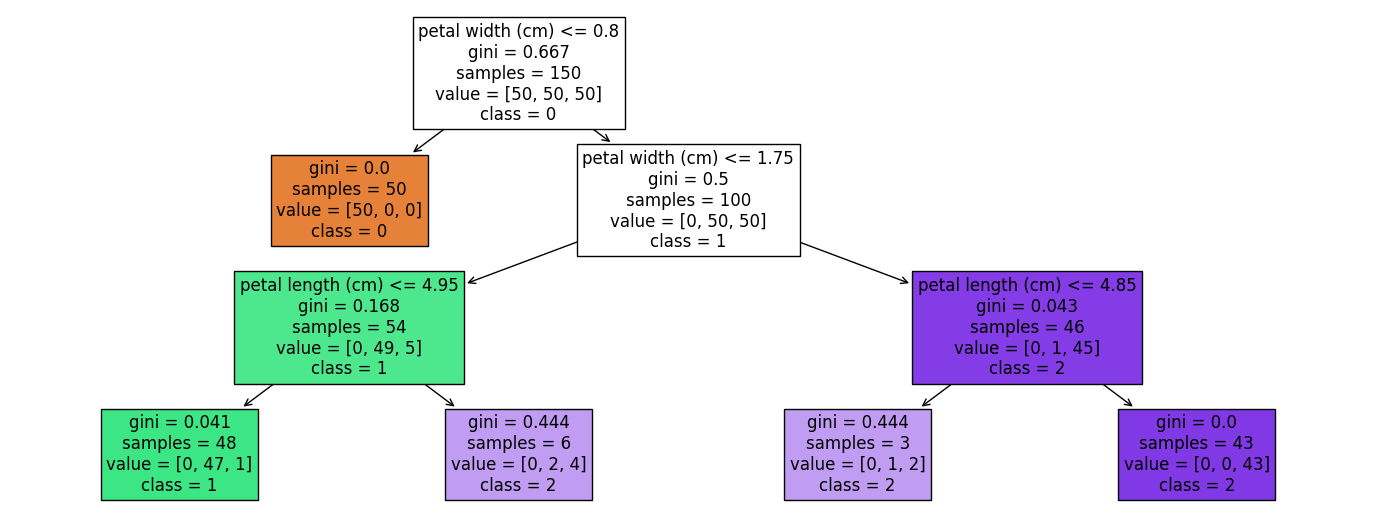

In [10]:
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

inspector = get_inspector(DecisionTreeClassifier(max_depth=3).fit(X, y), X, y)

ax = inspector.plot_tree()

In [11]:
#| export
_all_ = ["_TreeRegInspector", "_TreeBinInspector", "_TreeMultiInspector"]